In [1]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
np.set_printoptions(precision=3)
from sklearn.model_selection import train_test_split

In [130]:
def R2(y_data, y_model):
    y_data = np.squeeze(y_data)
    y_model= np.squeeze(y_model)
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data-np.mean(y_data))**2)
def MSE(y_data, y_model):
    return np.sum((np.squeeze(y_data)-np.squeeze(y_model))**2)/len(y_data)

In [131]:
n_points = 100
x = np.random.rand(n_points,1)
lvls = [0., 0.01, 1, 3]
y = {}
for lvl in lvls:
    y[lvl] = 7 + 5*np.power(x,2) + lvl*np.random.rand(n_points,1)

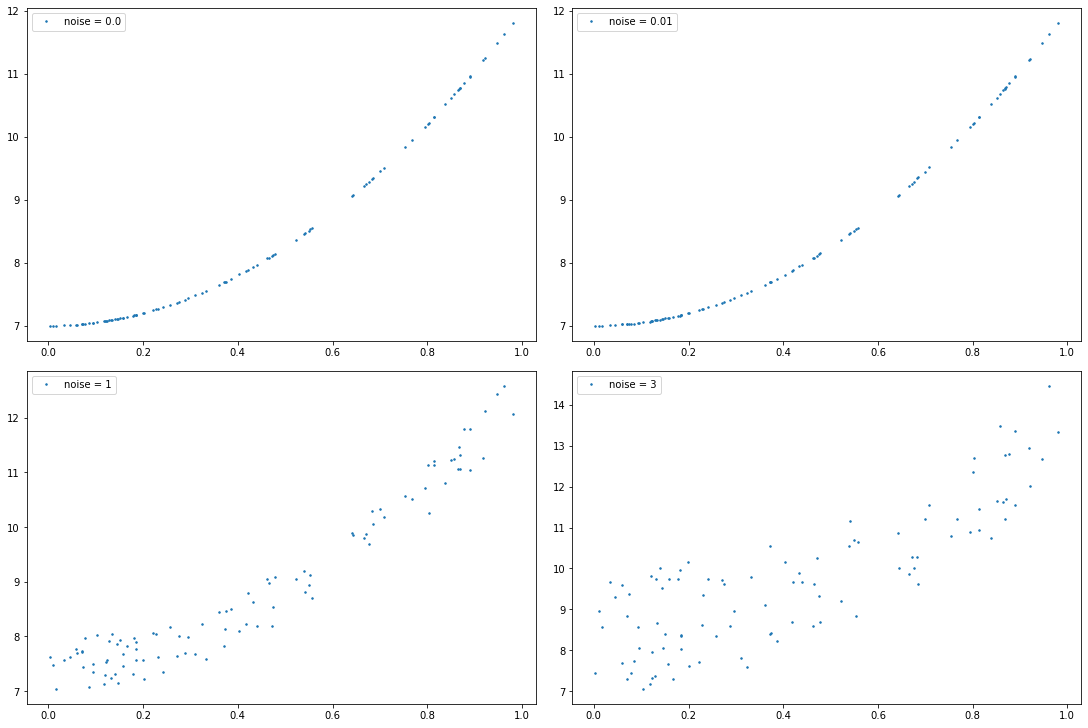

In [132]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15,10))
for ax,lvl in zip(axs.flat, lvls):
    ax.plot(x, y[lvl], '.', markersize=3, label=f'noise = {lvl}')
    ax.legend()

In [133]:
X, X_train, X_test = {},{},{}
y_train, y_test = {},{}
#x_plot_test, x_plot_train = collections.defaultdict(dict),collections.defaultdict(dict)

#Create dictinary for design matrix with different degrees of polynoms
deg = np.arange(3,24,3)

for degree in deg:
    X[degree] = np.zeros((len(x),degree))
    for i in range(degree):
            X[degree][:,i] = np.power(np.squeeze(x),i)

#Split data according to degree and level of noise with random state to prevent index shuffling (not really good solution but it works)
for degree in deg:            
    for lvl in lvls:
        X_train[degree], X_test[degree], y_train[lvl], y_test[lvl], x_plot_train, x_plot_test = train_test_split(X[degree], y[lvl], x, test_size=0.2, random_state=42)

#Basically we need number of poly degrees X_train and X_test sets and number of noise lvls of y_train and y_test sets
print(f'Number of X_ instances = {len(X_train.keys())}, y_ instances = {len(y_test.keys())}')

Number of X_ instances = 7, y_ instances = 4


In [134]:
import collections
#OLS for different poly degrees and noise levels
beta_ols, mse_train_OLS, mse_test_OLS = collections.defaultdict(dict),collections.defaultdict(dict),collections.defaultdict(dict)
y_tilde_train_OLS, y_tilde_test_OLS = collections.defaultdict(dict),collections.defaultdict(dict)

for degree in deg:
    for lvl in lvls:
        beta_ols[degree][lvl] = np.linalg.inv(X_train[degree].T.dot(X_train[degree])).dot(X_train[degree].T).dot(y_train[lvl])
        #--------------------------TRAIN-------------------------------------------
        y_tilde_train_OLS[degree][lvl] = X_train[degree].dot(beta_ols[degree][lvl])
        mse_train_OLS[degree][lvl] = MSE(y_train[lvl], y_tilde_train_OLS[degree][lvl])
        #--------------------------TEST-------------------------------------------
        y_tilde_test_OLS[degree][lvl] = X_test[degree].dot(beta_ols[degree][lvl])
        mse_test_OLS[degree][lvl] = MSE(y_test[lvl], y_tilde_test_OLS[degree][lvl])

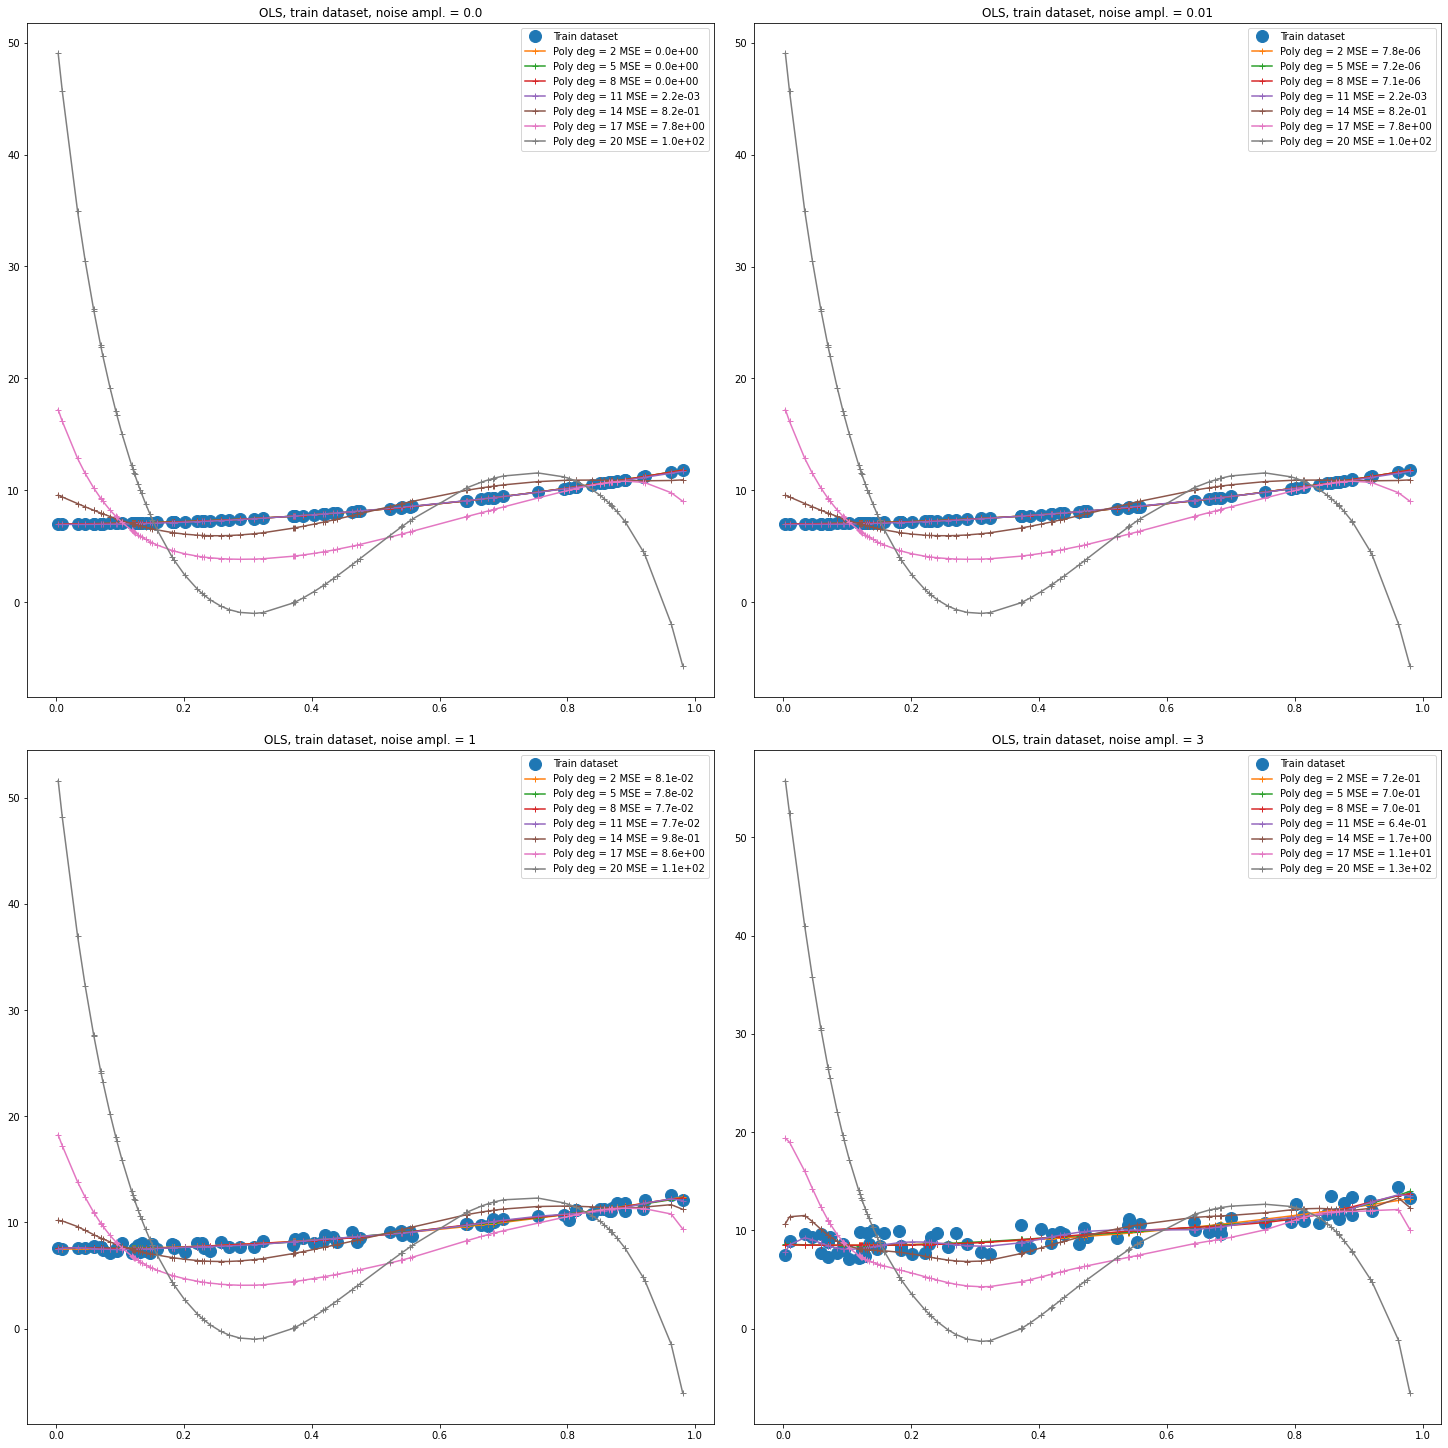

In [135]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(20,20))
for ax,lvl in zip(axs.flat, lvls):
    ax.plot(x_plot_train, y_train[lvl], 'o', markersize=12, label='Train dataset')
    ax.set_title(f'OLS, train dataset, noise ampl. = {lvl}')
    for degree in deg:
        x_ , y_ = zip(*sorted(zip(x_plot_train, y_tilde_train_OLS[degree][lvl]),key=lambda x_plot_train: x_plot_train[0]))
        ax.plot(x_, y_, '+-', label=f'Poly deg = {degree-1} MSE = {np.round(mse_train_OLS[degree][lvl],7):.1e}')
    ax.legend()

In [136]:
#fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(20,20))
#for ax,lvl in zip(axs.flat, lvls):
#    ax.plot(x_plot_test, y_test[lvl], 'o', markersize=12, label='Test dataset')
#    ax.set_title(f'OLS,test dataset, noise ampl. = {lvl}')
#    for degree in deg:
#        x_ , y_ = zip(*sorted(zip(x_plot_test, y_tilde_test_OLS[degree][lvl]),key=lambda x_plot_test: x_plot_test[0]))
#        ax.plot(x_ , y_ ,'+-', markersize=12, label=f'Poly deg = {degree-1} MSE = {np.round(mse_test_OLS[degree][lvl],7):.1e}')
#    ax.legend()

In [137]:
#------------------------------------------------------------------RIDGE----------------------------------------------------------------------------

In [138]:
#Parametrization for diffrent LAMBDAS
lmbds = np.logspace(-7, 4, 500)
lmbds_lasso = np.logspace(-2, 10, 500)

In [139]:
poly_deg = deg[6] # deg = array([ 3,  6,  9, 12, 15, 18, 21])
I = np.eye(poly_deg)
beta_ridge, y_tilde_ridge_train, mse_ridge_train = collections.defaultdict(dict),collections.defaultdict(dict),collections.defaultdict(dict)
y_tilde_ridge_test, mse_ridge_test = collections.defaultdict(dict),collections.defaultdict(dict)
for lvl in lvls:
    for lmbd in lmbds:
        beta_ridge[lmbd][lvl] = np.linalg.inv(X_train[poly_deg].T.dot(X_train[poly_deg])+lmbd*I).dot(X_train[poly_deg].T).dot(y_train[lvl])
        #--------------------------TRAIN-------------------------------------------
        y_tilde_ridge_train[lmbd][lvl] = X_train[poly_deg].dot(beta_ridge[lmbd][lvl])
        mse_ridge_train[lvl][lmbd] = MSE(y_train[lvl], y_tilde_ridge_train[lmbd][lvl])
        #--------------------------TEST-------------------------------------------
        y_tilde_ridge_test[lmbd][lvl] = X_test[poly_deg].dot(beta_ridge[lmbd][lvl])
        mse_ridge_test[lvl][lmbd] = MSE(y_test[lvl], y_tilde_ridge_test[lmbd][lvl])

In [140]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse

In [141]:
lin_reg = LinearRegression()

In [142]:
poly = {}
X_train_sk, X_test_sk = {}, {}
mse_OLS_train_sk, mse_OLS_test_sk = collections.defaultdict(dict),collections.defaultdict(dict)
mse_ridge_train_sk, mse_ridge_test_sk = collections.defaultdict(dict),collections.defaultdict(dict)
mse_lasso_train_sk, mse_lasso_test_sk = collections.defaultdict(dict),collections.defaultdict(dict)
deg_sk = deg-1

rid_degree = deg_sk[1]

for lvl in lvls:
    for degree in deg_sk:
        poly = PolynomialFeatures(degree=degree, include_bias=True)
        
        X_train_sk[degree], X_test_sk[degree] = train_test_split(poly.fit_transform(x), test_size=0.2, random_state=42)
    
        #Train models
        lin_reg.fit(X_train_sk[degree], y_train[lvl])
        
        mse_OLS_train_sk[degree][lvl] = MSE(y_train[lvl], lin_reg.predict(X_train_sk[degree]))
        mse_OLS_test_sk[degree][lvl] = MSE(y_test[lvl], lin_reg.predict(X_test_sk[degree]))
    
    for lmbd in lmbds:
        
        rid_reg = Ridge(alpha=lmbd)
        rid_reg.fit(X_train_sk[rid_degree], y_train[lvl])
        mse_ridge_train_sk[lvl][lmbd] = MSE(y_train[lvl], rid_reg.predict(X_train_sk[rid_degree]))
        mse_ridge_test_sk[lvl][lmbd] = MSE(y_test[lvl], rid_reg.predict(X_test_sk[rid_degree]))
        
    for lmbd in lmbds_lasso:
        
        las_reg = Lasso(alpha=lmbd)
        las_reg.fit(X_train_sk[rid_degree], y_train[lvl])
        mse_lasso_train_sk[lvl][lmbd] = MSE(y_train[lvl], las_reg.predict(X_train_sk[rid_degree]))
        mse_lasso_test_sk[lvl][lmbd] = MSE(y_test[lvl], las_reg.predict(X_test_sk[rid_degree]))

In [143]:
#np.allclose(X_train[3], X_train_sk[2])

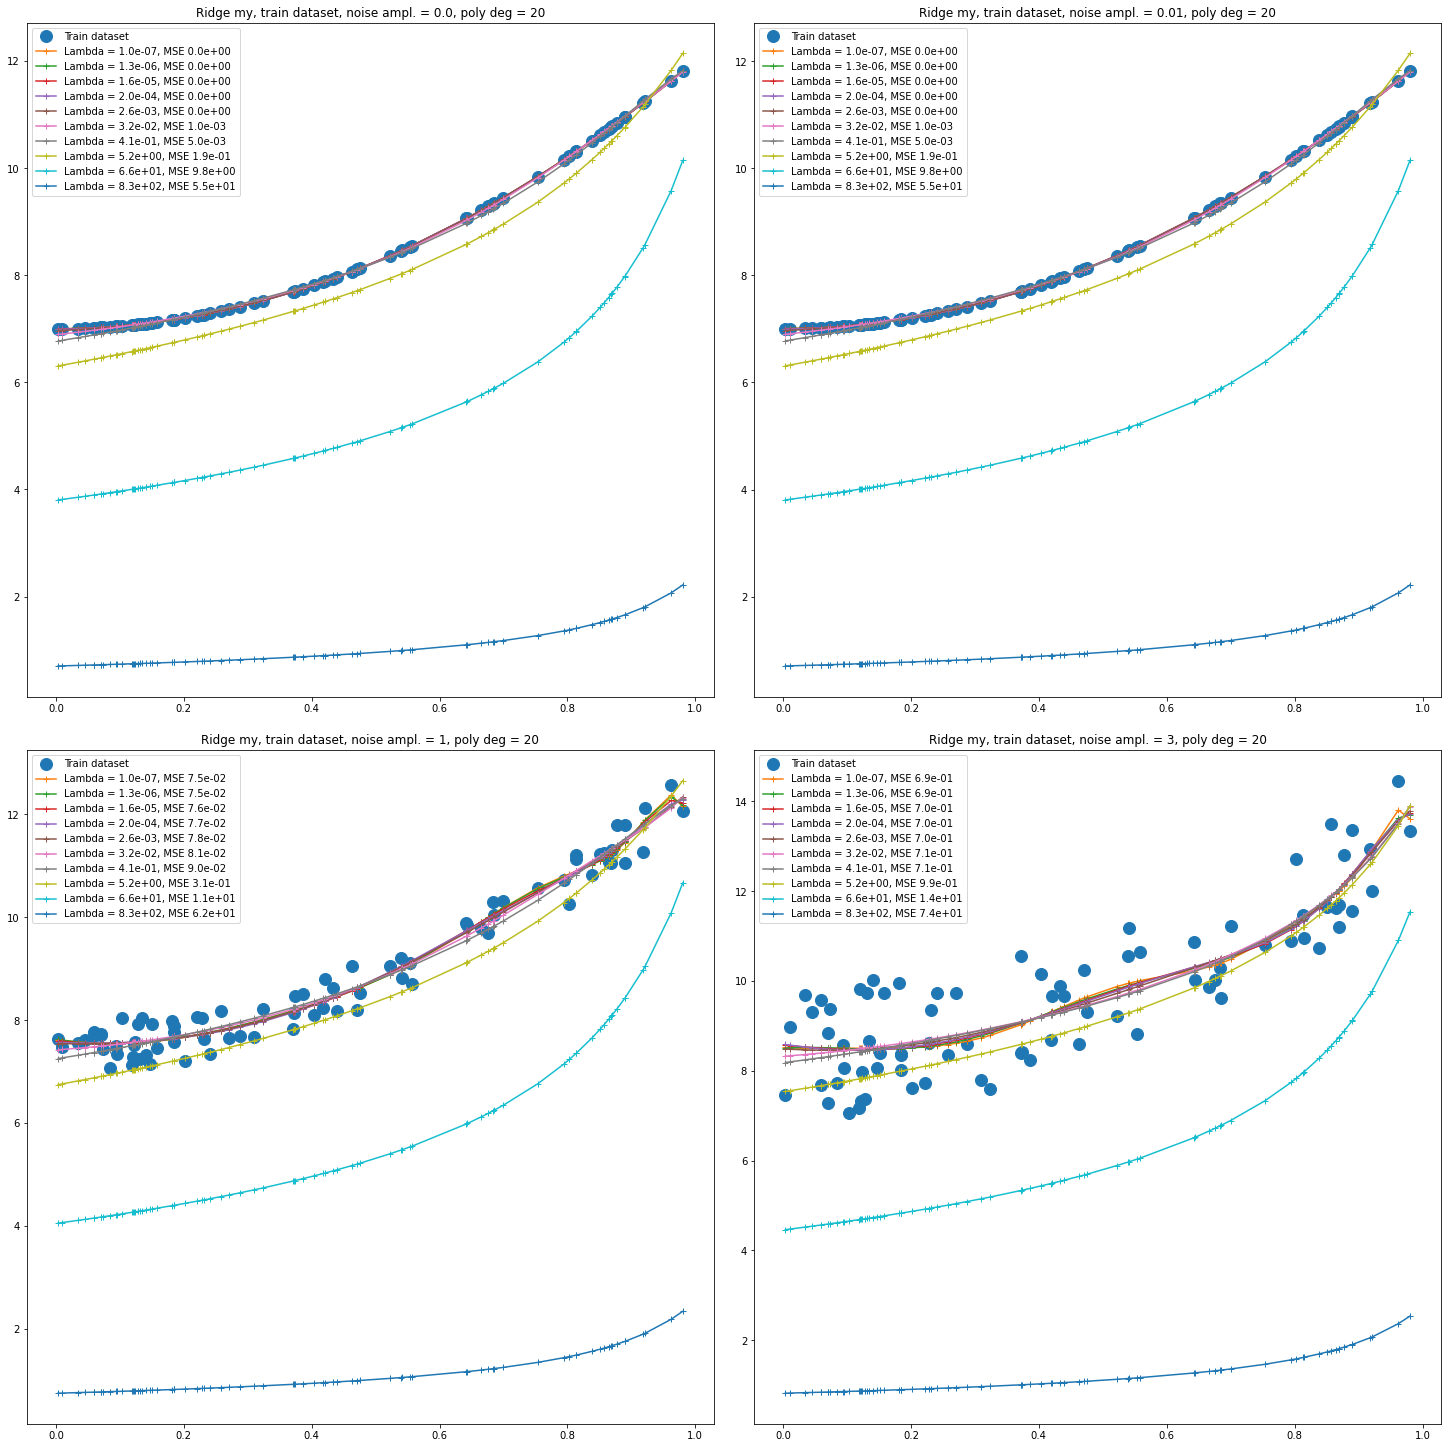

In [144]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(20,20))
for ax,lvl in zip(axs.flat, lvls):
    ax.plot(x_plot_train, y_train[lvl], 'o', markersize=12, label='Train dataset')
    ax.set_title(f'Ridge my, train dataset, noise ampl. = {lvl}, poly deg = {poly_deg-1}')
    for lmbd in lmbds[::50]:
        x_r , y_r = zip(*sorted(zip(x_plot_train, y_tilde_ridge_train[lmbd][lvl]),key=lambda x_plot_train: x_plot_train[0]))
        ax.plot(x_r, y_r, '+-', label=f'Lambda = {lmbd:.1e}, MSE {np.round(mse_ridge_train[lvl][lmbd],3):.1e}')
    ax.legend()

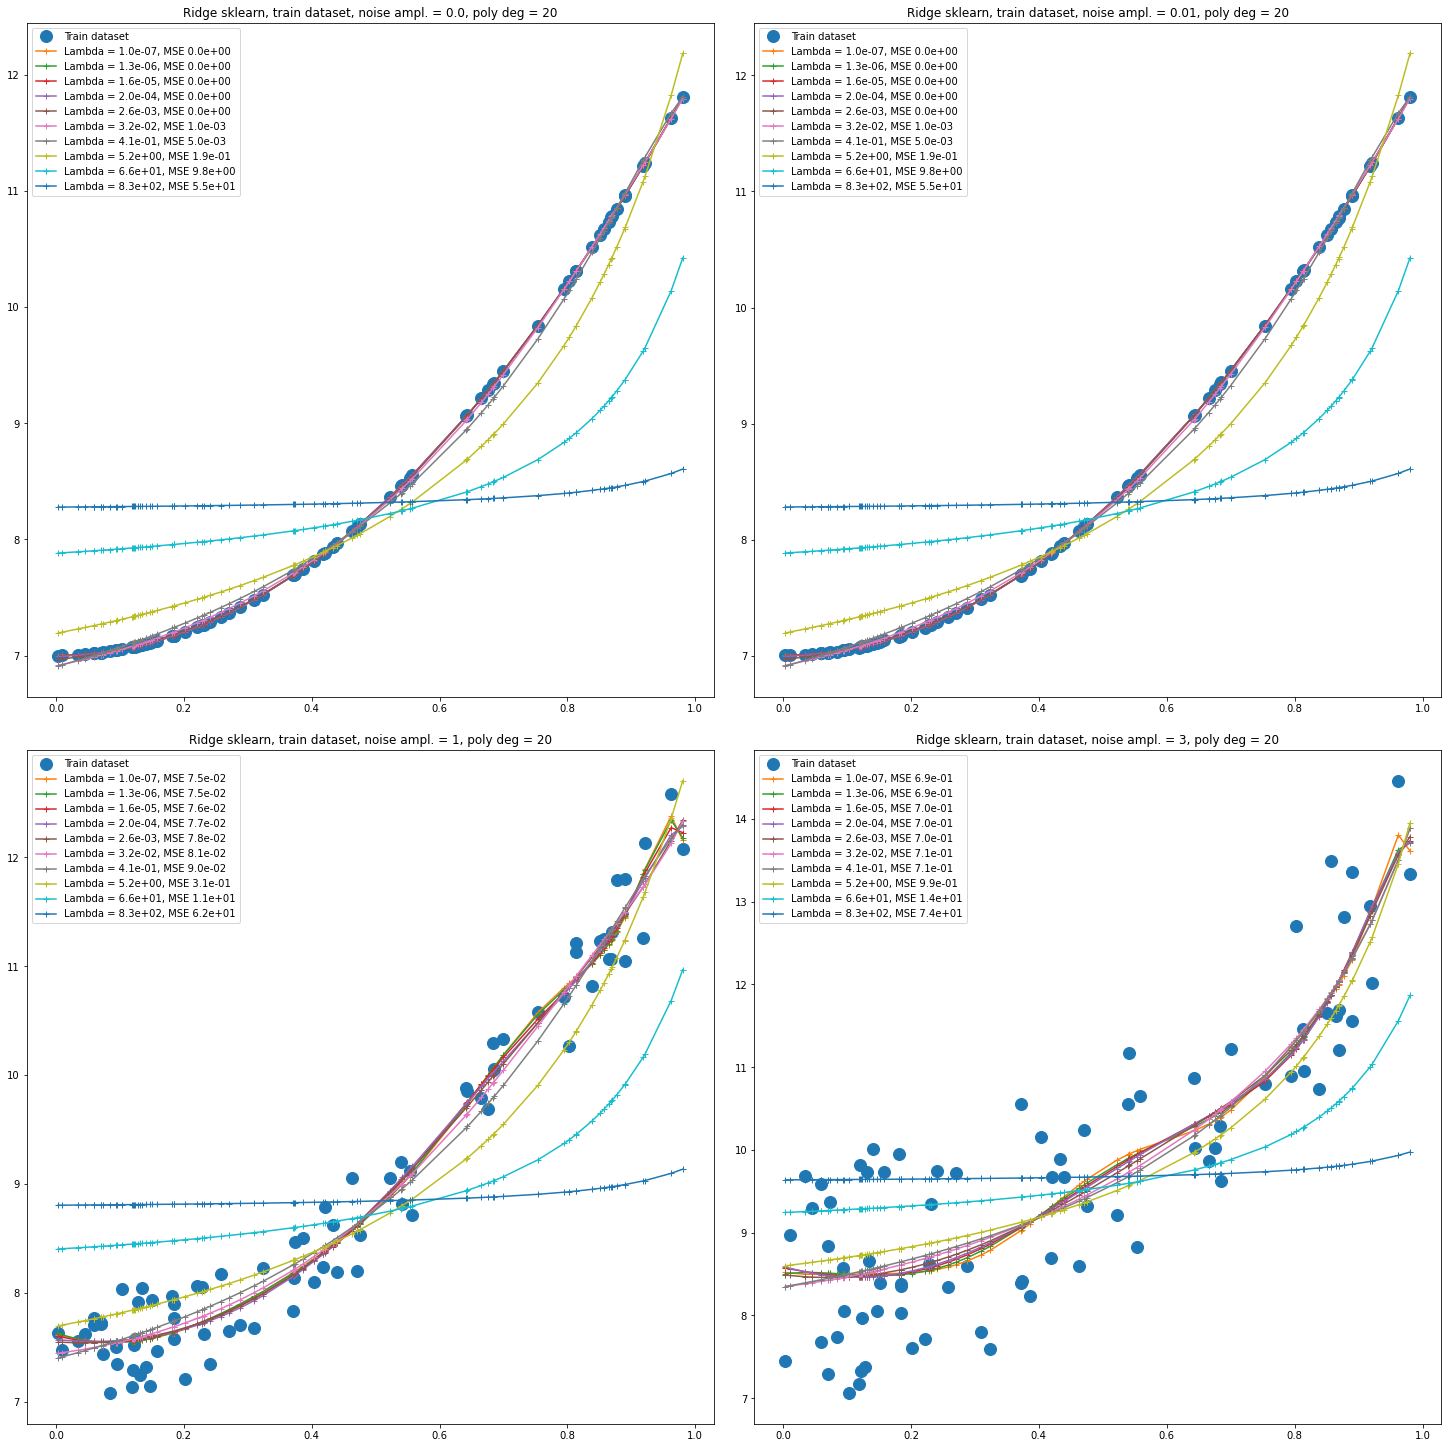

In [145]:
rid_degree = deg_sk[6]

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(20,20))
for ax,lvl in zip(axs.flat, lvls):
    ax.plot(x_plot_train, y_train[lvl], 'o', markersize=12, label='Train dataset')
    ax.set_title(f'Ridge sklearn, train dataset, noise ampl. = {lvl}, poly deg = {poly_deg-1}')
    for lmbd in lmbds[::50]:
        rid_reg = Ridge(alpha=lmbd)
        rid_reg.fit(X_train_sk[rid_degree], y_train[lvl])
        x_r , y_r = zip(*sorted(zip(x_plot_train, rid_reg.predict(X_train_sk[rid_degree])),key=lambda x_plot_train: x_plot_train[0]))
        ax.plot(x_r, y_r, '+-', label=f'Lambda = {lmbd:.1e}, MSE {np.round(mse_ridge_train[lvl][lmbd],3):.1e}')
    ax.legend()

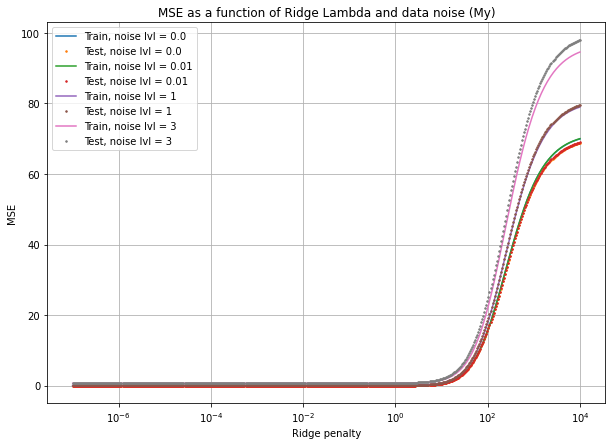

In [169]:
plt.figure(figsize=(10,7))
plt.title('MSE as a function of Ridge Lambda and data noise (My)')
for lvl in lvls:
    _ , mse_ridge_tr = zip(*list(zip(mse_ridge_train[lvl].keys(), mse_ridge_train[lvl].values())))
    _ , mse_ridge_te = zip(*list(zip(mse_ridge_test[lvl].keys(), mse_ridge_test[lvl].values())))
    plt.plot(lmbds, np.array(mse_ridge_tr), '-', label=f'Train, noise lvl = {lvl}')
    plt.plot(lmbds, np.array(mse_ridge_te), '.', markersize=3, label=f'Test, noise lvl = {lvl}')
    plt.legend()
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('Ridge penalty')
    plt.ylabel('MSE')
plt.grid()

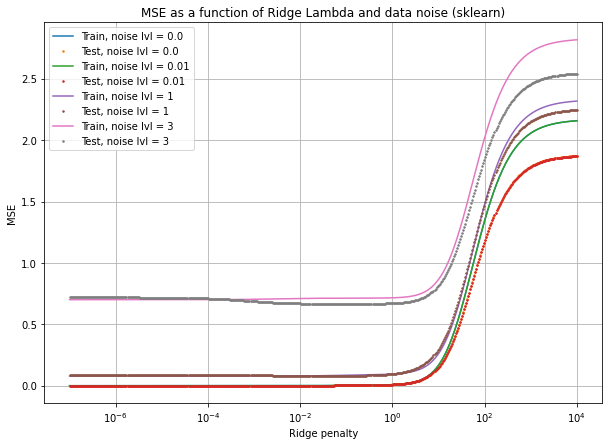

In [147]:
plt.figure(figsize=(10,7))
plt.title('MSE as a function of Ridge Lambda and data noise (sklearn)')
for lvl in lvls[:]:
    _ , mse_ridge_tr = zip(*list(zip(mse_ridge_train_sk[lvl].keys(), mse_ridge_train_sk[lvl].values())))
    _ , mse_ridge_te = zip(*list(zip(mse_ridge_test_sk[lvl].keys(), mse_ridge_test_sk[lvl].values())))
    plt.plot(lmbds, np.array(mse_ridge_tr), '-', label=f'Train, noise lvl = {lvl}')
    plt.plot(lmbds, np.array(mse_ridge_te), '.', markersize=3, label=f'Test, noise lvl = {lvl}')
    plt.legend()
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('Ridge penalty')
    plt.ylabel('MSE')
plt.grid()

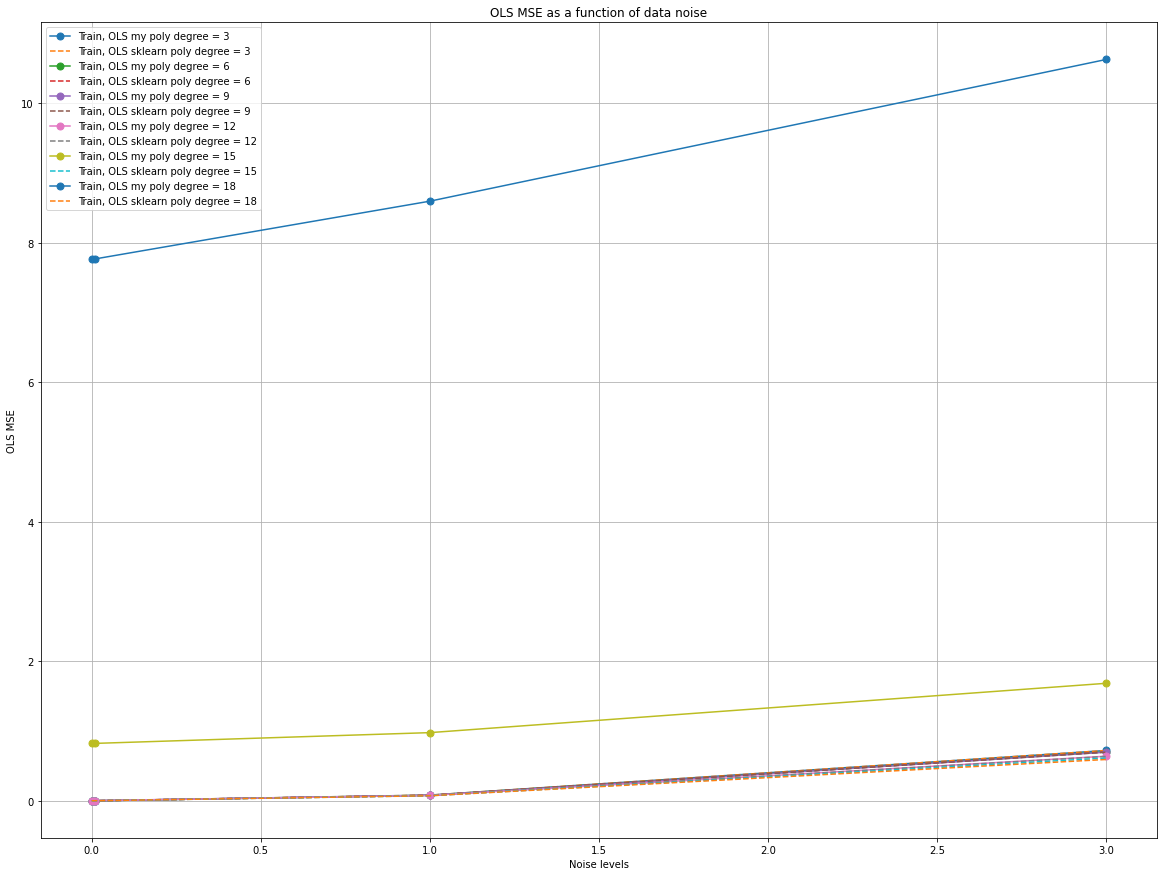

In [155]:
plt.figure(figsize=(20,15))
plt.title('OLS MSE as a function of data noise')
for degree in deg[:6]:
    _ , mse_OLS_tr = zip(*list(zip(mse_train_OLS[degree].keys(), mse_train_OLS[degree].values())))
    #_ , mse_OLS_test = zip(*list(zip(mse_test_OLS[degree].keys(), mse_test_OLS[degree].values())))
    _ , mse_OLS_tr_sk = zip(*list(zip(mse_OLS_train_sk[degree-1].keys(), mse_OLS_train_sk[degree-1].values())))
    #_ , mse_OLS_test = zip(*list(zip(mse_test_OLS[degree].keys(), mse_test_OLS[degree].values())))
    plt.plot(lvls, np.array(mse_OLS_tr), 'o-', markersize=7, label=f'Train, OLS my poly degree = {degree}')
    plt.plot(lvls, np.array(mse_OLS_tr_sk), '--', label=f'Train, OLS sklearn poly degree = {degree}')
    plt.legend()
    #plt.xscale('log')
    plt.xlabel('Noise levels')
    plt.ylabel('OLS MSE')
plt.grid()

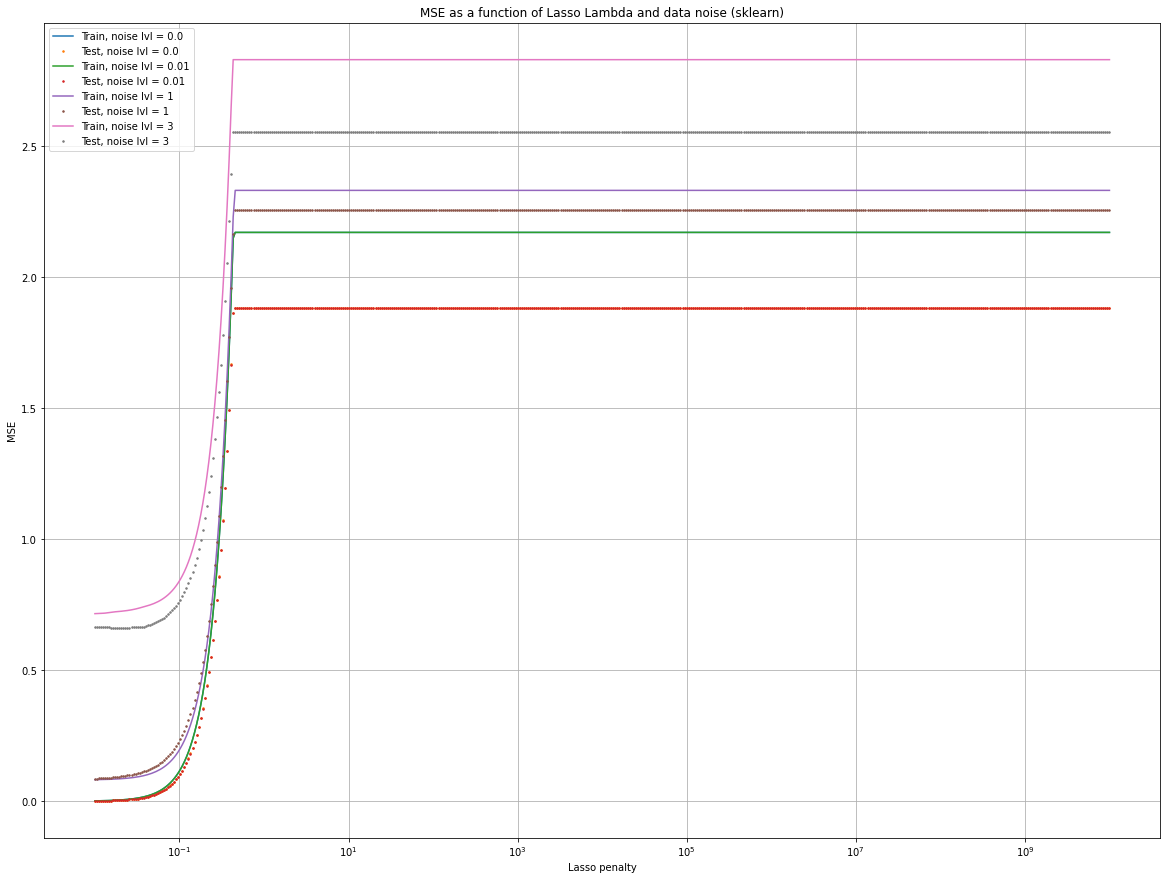

In [157]:
plt.figure(figsize=(20,15))
plt.title('MSE as a function of Lasso Lambda and data noise (sklearn)')
for lvl in lvls[:]:
    _ , mse_lasso_tr = zip(*list(zip(mse_lasso_train_sk[lvl].keys(), mse_lasso_train_sk[lvl].values())))
    _ , mse_lasso_te = zip(*list(zip(mse_lasso_test_sk[lvl].keys(), mse_lasso_test_sk[lvl].values())))
    plt.plot(lmbds_lasso, np.array(mse_lasso_tr), '-', label=f'Train, noise lvl = {lvl}')
    plt.plot(lmbds_lasso, np.array(mse_lasso_te), '.', markersize=3, label=f'Test, noise lvl = {lvl}')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Lasso penalty')
    plt.ylabel('MSE')
plt.grid()

In [158]:
# Variance of the regression parameters

In [159]:
polynom = PolynomialFeatures(degree=2, include_bias=True)

In [161]:
x_2deg = polynom.fit_transform(x)

In [163]:
L = 0.01
I = np.eye(3)
mtrx = np.linalg.inv(x_2deg.T.dot(x_2deg)+L*I)

In [168]:
var_b0, var_b1, var_b3 = mtrx.diagonal()
print(f'Variance = {var_b0, var_b1, var_b3}')

Variance = (0.06795972381710427, 1.9858125559247144, 2.0674227731567485)
